# Sample Lya posterior as a function of nuisance parameters

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
import corner
# our own modules
import mf_emulator
import data_MPGADGET
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler

### Setup Lya likelihood function

In [2]:
# read P1D measurement
#data=data_PD2013.P1D_PD2013(blind_data=True,zmin=2.1,zmax=4.7)
data=data_MPGADGET.P1D_MPGADGET(filename="1024_L90_mimic.json",z_list=[2.0,3.0,4.0])
zs=data.z

In [3]:
#basedir='../../p1d_emulator/sim_suites/emulator_512_18062019/'
#basedir='../../p1d_emulator/sim_suites/emulator_512_17052019/'
basedir='../../p1d_emulator/sim_suites/emulator_256_15072019/'
kmax_Mpc=4.0
p1d_label=None
skewers_label='Ns256_wM0.05'
undersample_z=1
max_arxiv_size=2000
paramList=["Delta2_p","n_p","mF","sigT_Mpc","gamma","kF_Mpc"]
emu_type='mf'
if emu_type=='polyfit':
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,emu_type=emu_type,
                                kmax_Mpc=kmax_Mpc,verbose=False,paramList=paramList,train=True)
elif emu_type=='k_bin':
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                               undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                               verbose=False,paramList=paramList,train=True,emu_type=emu_type)
elif emu_type=='linear':
    # specify parameters to emulate
    emulate_slope=False
    emulate_growth=False
    emulate_running=False
    emulate_pressure=True
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,kmax_Mpc=kmax_Mpc,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                emulate_slope=emulate_slope,emulate_running=emulate_running,
                                emulate_pressure=emulate_pressure,emulate_growth=emulate_growth,verbose=False)
elif emu_type=='NGP':
    emu=simplest_emulator.SimplestEmulator(basedir,p1d_label,skewers_label,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                verbose=False)
elif emu_type=='mf':
    emu=mf_emulator.MeanFluxEmulator(basedir,p1d_label,skewers_label,
                                kmax_Mpc=kmax_Mpc,emu_type='k_bin',
                                max_arxiv_size=None,
                                verbose=True,paramList=paramList,train=True)
else:
    raise ValueError('wrong emulator type '+emu_type)

0 0.05 0.0 <mf< 0.15000000000000002
1 0.15 0.04999999999999999 <mf< 0.25
2 0.25 0.15 <mf< 0.35
3 0.35 0.24999999999999997 <mf< 0.44999999999999996
4 0.44999999999999996 0.35 <mf< 0.5499999999999999
5 0.5499999999999999 0.44999999999999996 <mf< 0.6499999999999999
6 0.65 0.55 <mf< 0.75
7 0.75 0.65 <mf< 0.85
8 0.85 0.75 <mf< 0.95
9 0.95 0.85 <mf< 1.0
latin hyper-cube data {'param_space': {'Delta2_star': {'ip': 0, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 1, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'heat_amp': {'ip': 2, 'min_val': 0.3, 'max_val': 3.0, 'latex': '$H_A$'}, 'heat_slo': {'ip': 3, 'min_val': -1.5, 'max_val': 1.5, 'latex': '$H_S$'}, 'z_rei': {'ip': 4, 'min_val': 5.5, 'max_val': 16.0, 'latex': '$z_r$'}}, 'nsamples': 50, 'samples': {'0': [0.392, -2.319, 2.757, -0.4500000000000002, 11.905000000000001], '1': [0.268, -2.327, 1.0830000000000002, -1.41, 6.025], '2': [0

34 sample has sim params = [0.332, -2.323, 0.651, -0.9299999999999999, 12.115]
simulation has 3 redshifts
undersample_z = 1
35 sample has sim params = [0.328, -2.349, 0.867, -0.27, 9.175]
simulation has 3 redshifts
undersample_z = 1
36 sample has sim params = [0.41600000000000004, -2.315, 1.0290000000000001, 0.27, 15.475]
simulation has 3 redshifts
undersample_z = 1
37 sample has sim params = [0.316, -2.261, 0.597, 1.17, 14.424999999999999]
simulation has 3 redshifts
undersample_z = 1
38 sample has sim params = [0.252, -2.321, 0.5429999999999999, -0.1499999999999999, 14.845]
simulation has 3 redshifts
undersample_z = 1
39 sample has sim params = [0.40800000000000003, -2.273, 1.7850000000000004, -0.33000000000000007, 10.434999999999999]
simulation has 3 redshifts
undersample_z = 1
40 sample has sim params = [0.42000000000000004, -2.317, 1.461, 0.6299999999999999, 7.915]
simulation has 3 redshifts
undersample_z = 1
41 sample has sim params = [0.336, -2.339, 2.4330000000000003, 0.93000000

 /home/font/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


6750 initial entries
use 353/6750 entries
build emulator 1/10, <F>=0.150
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
will train GP emulator
Training GP on 353 points
Optimised
6750 initial entries
use 859/6750 entries
build emulator 2/10, <F>=0.250
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
will train GP emulator
Training GP on 859 points
Optimised
6750 initial entries
use 1221/6750 entries
build emulator 3/10, <F>=0.350
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
will train GP emulator
Training GP on 1221 points
Optimised
6750 initial entries
use 1409/6750 entries
build emulator 4/10, <F>=0.450
Loading emulator using a specific arxiv, not the one set in basedi

In [4]:
#theory=lya_theory.LyaTheory(zs,emulator=emu)
theory=lya_theory.get_mock_theory(zs,emulator=emu)

Note: redshifts have been re-sorted (earliest first)


In [5]:
# specify free parameters in likelihood
#free_parameters=['ln_kF_0']
#free_parameters=['ln_tau_0','ln_tau_1']
#free_parameters=['ln_tau_0','ln_tau_1','ln_gamma_0','ln_kF_0']
free_parameters=['ln_tau_0','ln_tau_1','ln_gamma_0','ln_kF_0','T0_1','T0_2','T0_3']
min_kp_kms=0.003
prior_Gauss_rms=0.02
# ignore emulator covariance for now
ignore_emu_cov=True
like=likelihood.Likelihood(data=data,theory=theory,free_parameters=free_parameters,
                           min_kp_kms=min_kp_kms,ignore_emu_cov=ignore_emu_cov,
                           prior_Gauss_rms=prior_Gauss_rms,verbose=True)

likelihood setup with 7 free parameters
7 free parameters


In [6]:
for p in like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

ln_tau_0 -1.03436530241446 -1.5 -0.5
ln_tau_1 3.6744666006830182 2.5 3.8
T0_1 0.13626544653787526 0 1
T0_2 9.546039892898634 7 11
T0_3 -1.2041429220366868 -2 -0.5
ln_gamma_0 0.3295042060454974 0.09531017980432493 0.6931471805599453
ln_kF_0 -0.8077668277205104 -2.995732273553991 -0.6931471805599453


In [7]:
sampler = emcee_sampler.EmceeSampler(like=like,verbose=True,nwalkers=2*len(like.free_params)+2)

use input likelihood
setup with 16 walkers
set 16 walkers with 7 dimensions
done setting up sampler


### Run burn-in chains

In [8]:
sampler.like.go_silent()

In [9]:
sampler.run_burn_in(nsteps=500)

start burn-in, will do 500 steps
0 [0.45714739 0.90510904 0.13954255 0.63585362 0.52368327 0.39642248
 0.94467305]
20 [0.41740183 0.94669593 0.13877188 0.60752676 0.48619923 0.37881252
 0.92874346]
40 [0.41125416 0.9636464  0.08891921 0.55761452 0.4007297  0.24165478
 0.93078795]
60 [0.42361674 0.93326848 0.07863551 0.55974341 0.40474651 0.10529679
 0.90147008]
80 [0.44202488 0.90911088 0.12123775 0.59489696 0.44200938 0.06169231
 0.84990583]
100 [0.44294243 0.88654856 0.17117959 0.57760907 0.44166259 0.06394725
 0.85138391]
120 [0.44187584 0.86835222 0.20403924 0.566417   0.44509567 0.07526182
 0.85425048]
140 [0.43568544 0.84790819 0.21966487 0.57129308 0.46820821 0.0875274
 0.85622593]
160 [0.42571303 0.83142615 0.23705436 0.57338521 0.48672402 0.10553078
 0.86045466]
180 [0.41802841 0.82738013 0.23860225 0.54998842 0.4913271  0.10682626
 0.8790969 ]
200 [0.40081203 0.82751946 0.24340125 0.5451938  0.50804393 0.1214824
 0.89632452]
220 [0.38932243 0.82628857 0.24455531 0.52814851 0.

### Run main chains

In [10]:
sampler.run_chains(nsteps=2000)

0 [0.35566189 0.82518975 0.22324643 0.49925653 0.53624032 0.19091635
 0.94477583]
20 [0.35317242 0.83071049 0.22556439 0.49640949 0.53312088 0.19989994
 0.94389033]
40 [0.34957082 0.8458653  0.21245634 0.49780619 0.53632384 0.20228949
 0.94311883]
60 [0.34714404 0.85136176 0.21568386 0.50112684 0.5411538  0.20820174
 0.93985099]
80 [0.34446999 0.85872379 0.207562   0.49804823 0.55141683 0.21804421
 0.94202371]
100 [0.34238046 0.85647739 0.17769917 0.47662976 0.55445925 0.21147005
 0.95846483]
120 [0.337736   0.85237458 0.16934971 0.46252906 0.56902955 0.21693483
 0.97038354]
140 [0.34109711 0.84567513 0.16320259 0.45947688 0.57810009 0.23177548
 0.96839226]
160 [0.34016175 0.83703697 0.14923141 0.4541689  0.59619145 0.25264442
 0.97032434]
180 [0.34056685 0.82705728 0.1496916  0.45158159 0.59880541 0.2647951
 0.96974123]
200 [0.3402272  0.82359811 0.15686353 0.44710816 0.59420591 0.27175108
 0.97204191]
220 [0.34081467 0.81883907 0.16715975 0.44565569 0.58842297 0.27921247
 0.96869931]

1960 [0.21125757 0.82661717 0.13489143 0.47780815 0.51791192 0.38016938
 0.99139774]
1980 [0.21191713 0.82811389 0.13972947 0.48147528 0.51890165 0.37791743
 0.98942725]


In [11]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.sampler.acceptance_fraction)))

Mean acceptance fraction: 0.372


### Plot results in cube units (0 < x < 1)

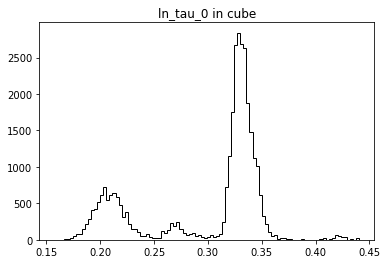

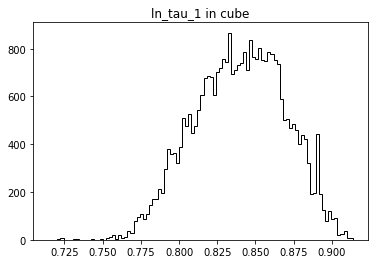

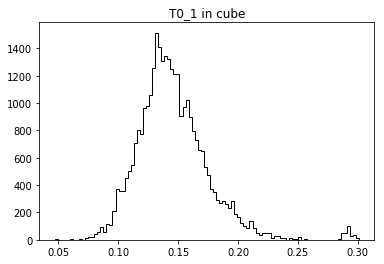

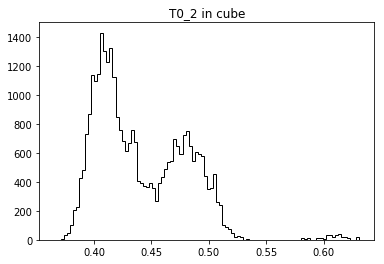

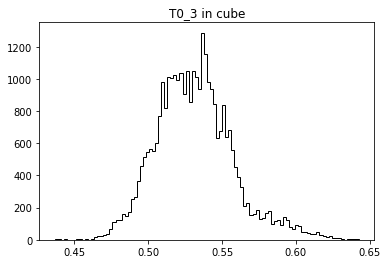

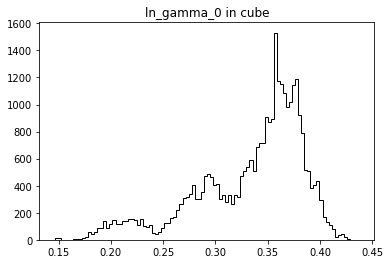

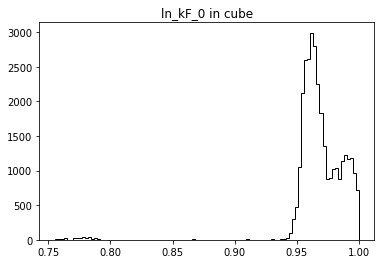

In [12]:
sampler.plot_histograms(cube=True)

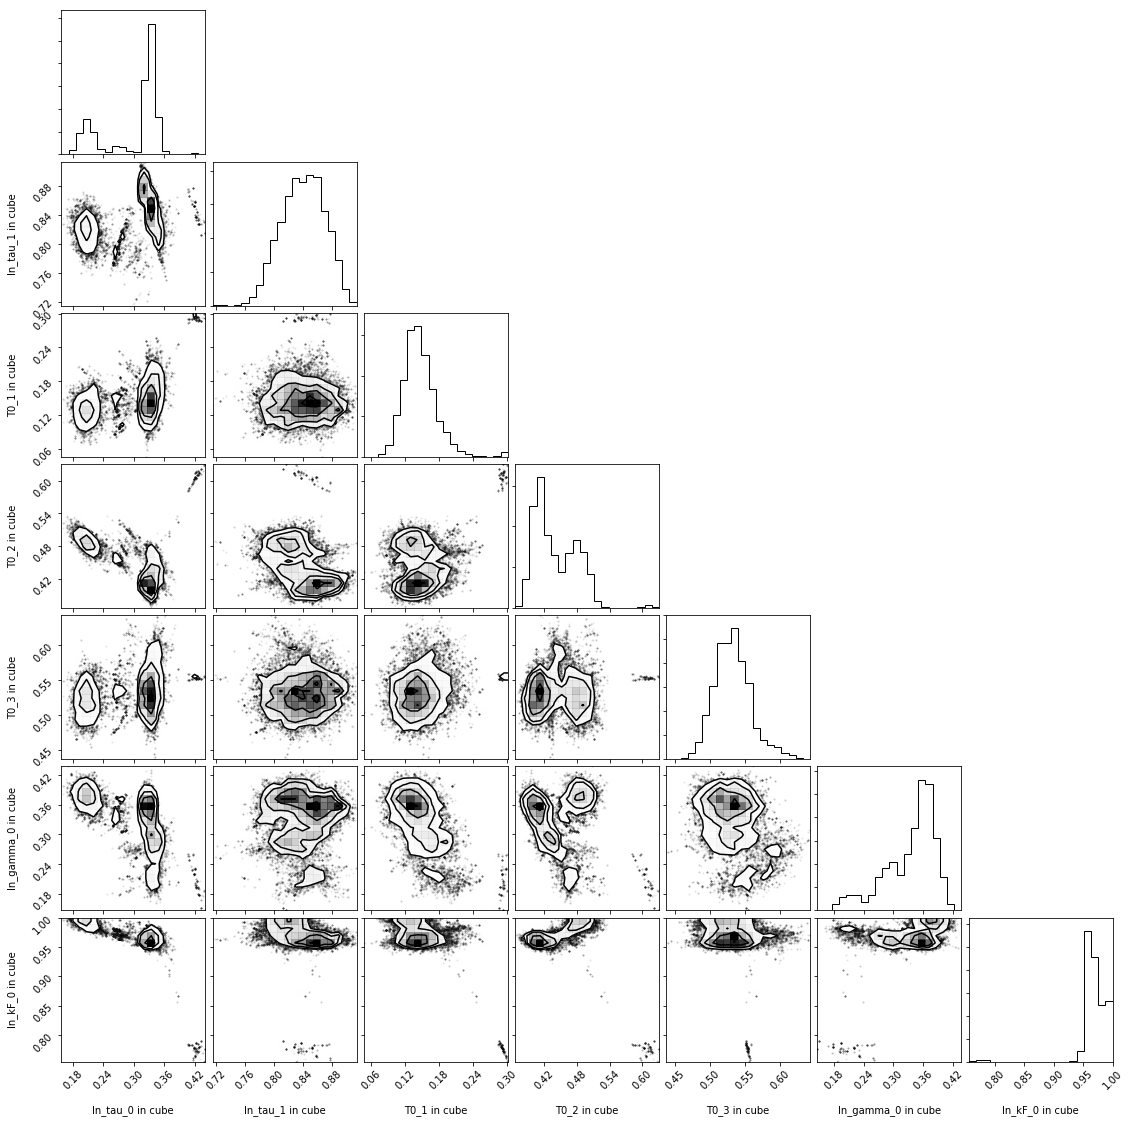

In [13]:
sampler.plot_corner(cube=True)

### Plot results for dimensional parameters

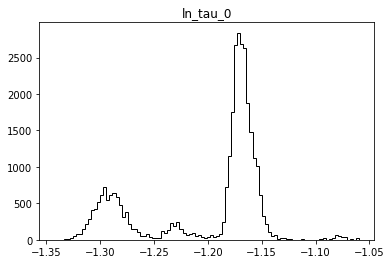

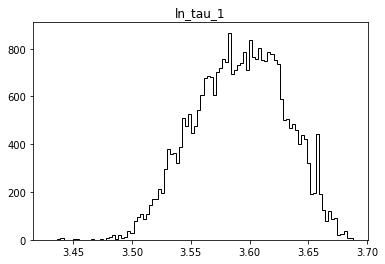

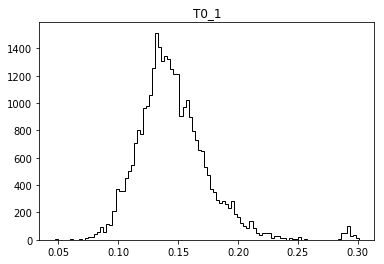

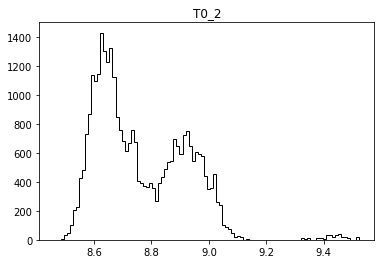

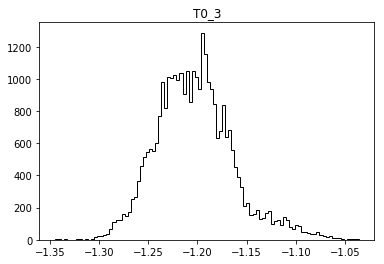

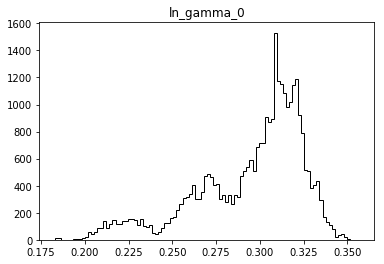

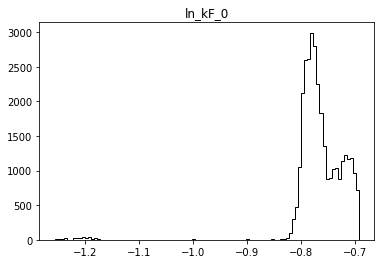

In [14]:
sampler.plot_histograms(cube=False)

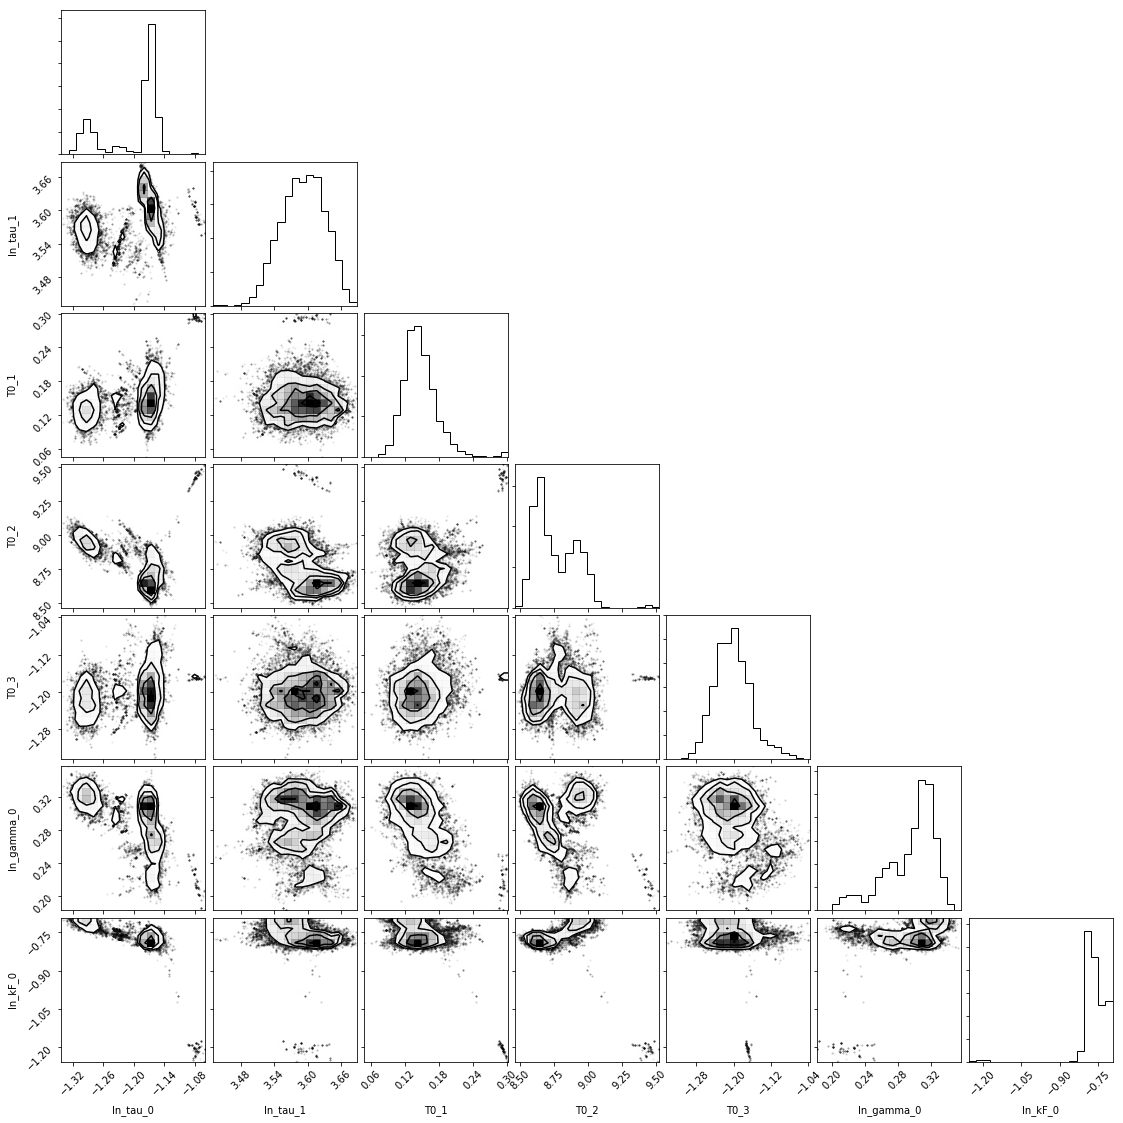

In [15]:
sampler.plot_corner(cube=False)

### Use likelihood object to make other useful plots

In [16]:
# get best fit model
ind = np.unravel_index(np.argmax(sampler.sampler.lnprobability, axis=None), sampler.sampler.lnprobability.shape)
best_fit=sampler.sampler.chain[ind]

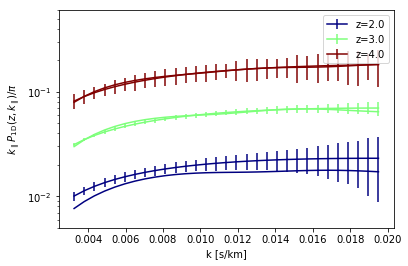

In [17]:
sampler.like.plot_p1d(values=best_fit,plot_every_iz=1)

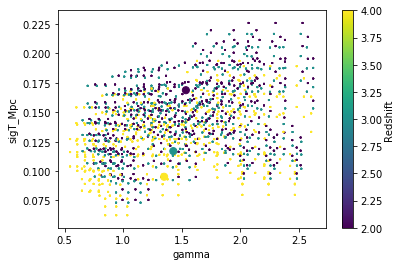

In [18]:
sampler.like.overplot_emulator_calls('gamma','sigT_Mpc',values=best_fit)

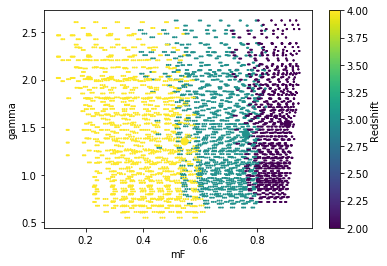

In [19]:
sampler.like.overplot_emulator_calls('mF','gamma',values=best_fit)

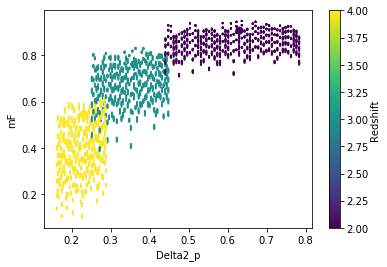

In [20]:
sampler.like.overplot_emulator_calls('Delta2_p','mF',values=best_fit)

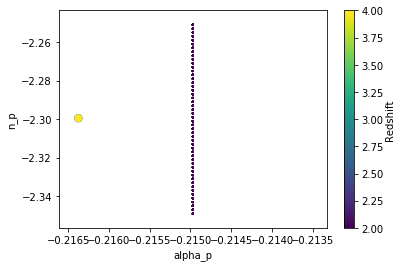

In [21]:
sampler.like.overplot_emulator_calls('alpha_p','n_p',values=best_fit)

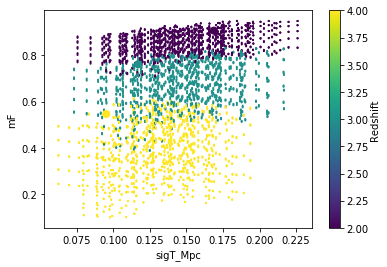

In [22]:
sampler.like.overplot_emulator_calls('sigT_Mpc','mF',values=best_fit)

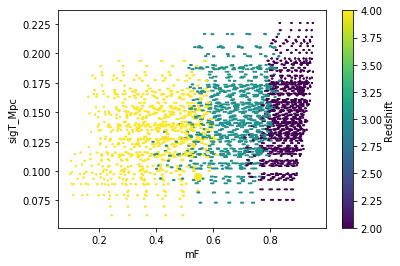

In [23]:
sampler.like.overplot_emulator_calls('mF','sigT_Mpc',values=best_fit)

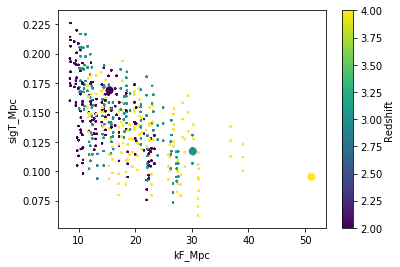

In [24]:
sampler.like.overplot_emulator_calls('kF_Mpc','sigT_Mpc',values=best_fit)

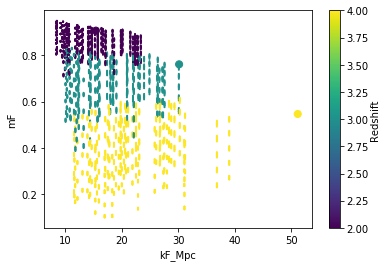

In [25]:
sampler.like.overplot_emulator_calls('kF_Mpc','mF',values=best_fit)

### Write chain to file for later use

In [26]:
chain_filename='test'
sampler.write_chain_to_file(chain_filename)

### Read pre-computed chain

In [27]:
new_sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,
                                         read_chain_file=chain_filename,verbose=True)

use default likelihood
Note: redshifts have been re-sorted (earliest first)
will read chain from file test
done setting up sampler


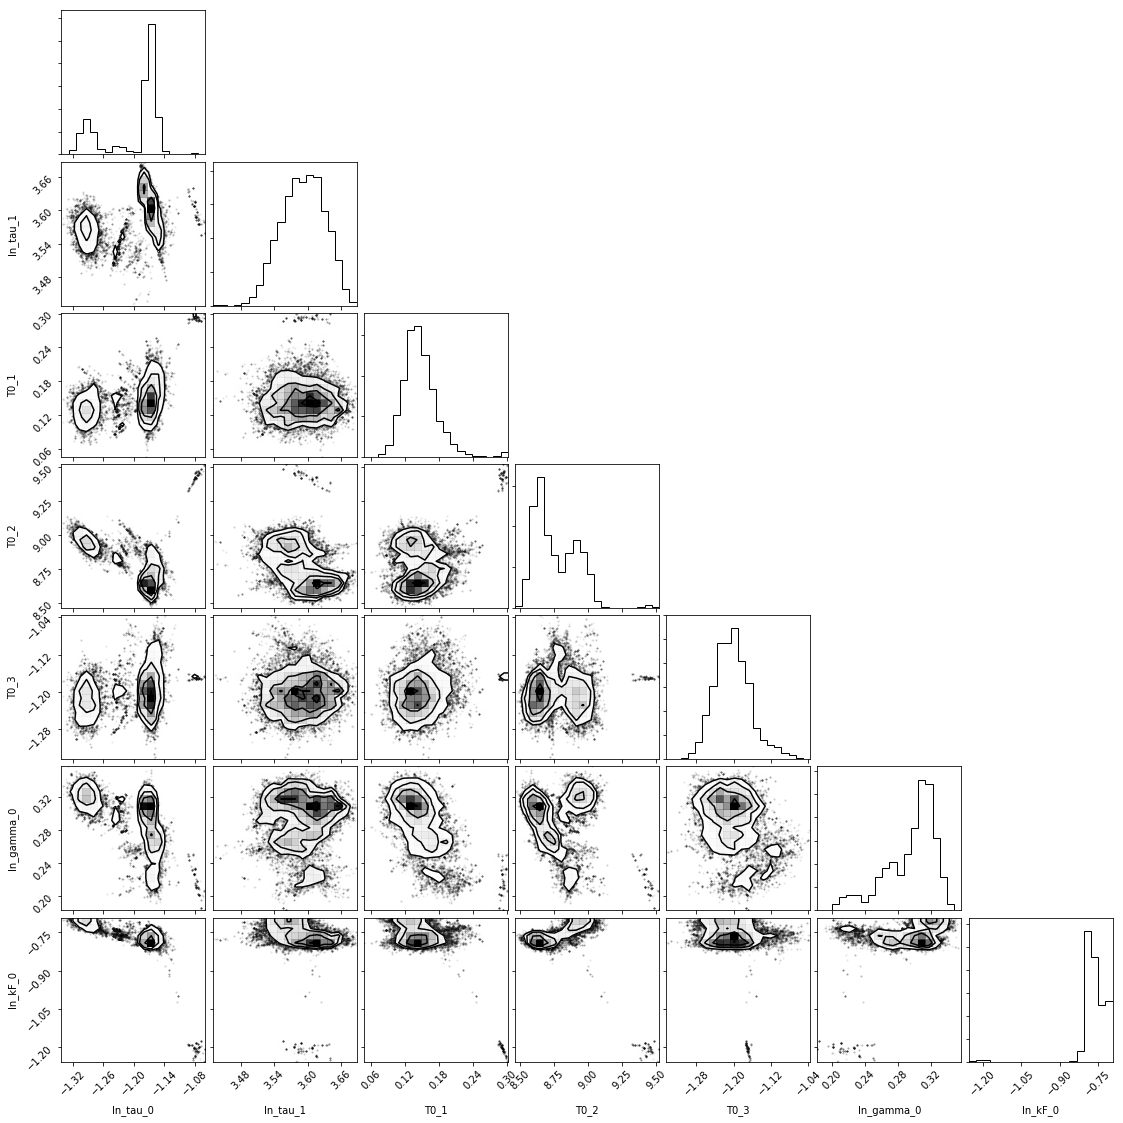

In [28]:
new_sampler.plot_corner(cube=False)

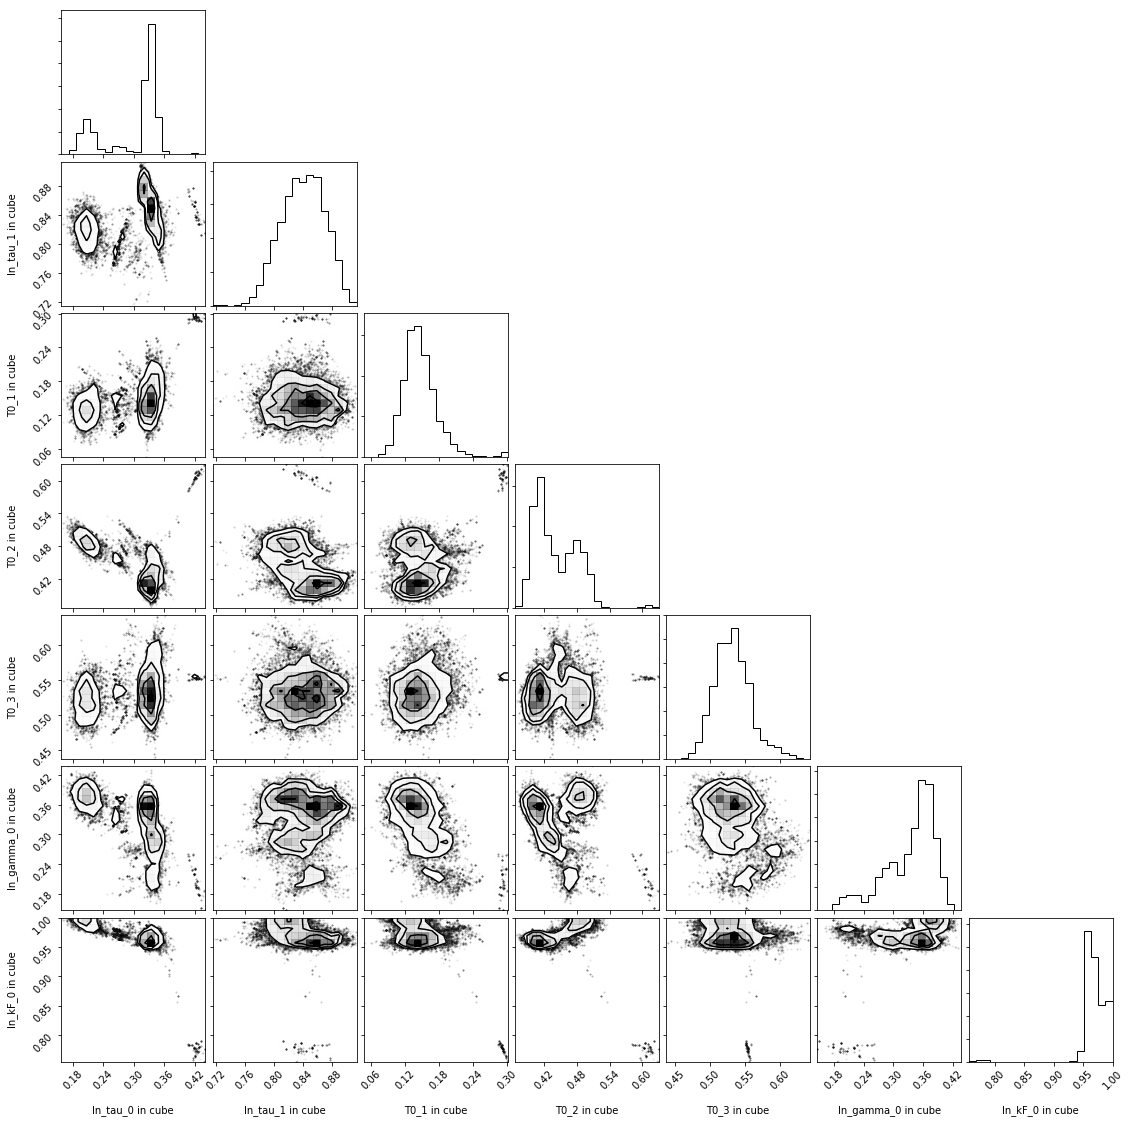

In [29]:
new_sampler.plot_corner(cube=True)

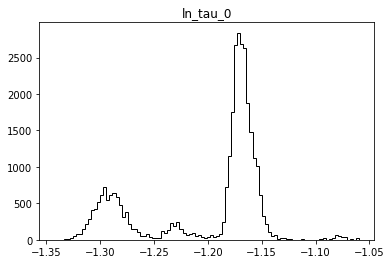

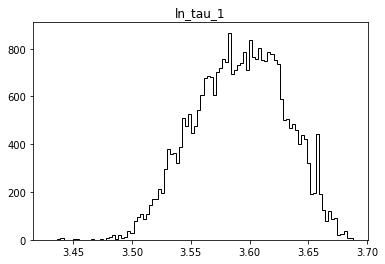

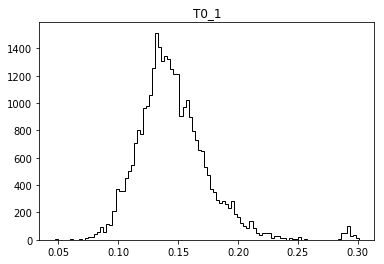

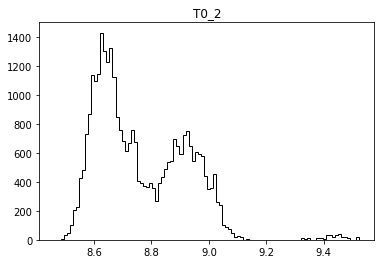

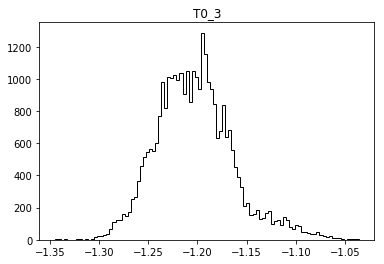

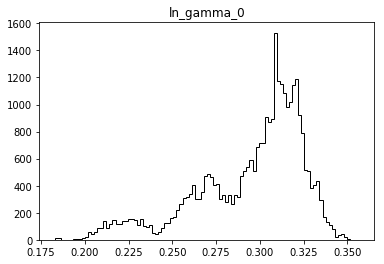

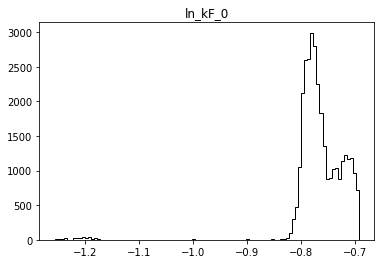

In [30]:
new_sampler.plot_histograms(cube=False)